In [1]:
import xarray as xr
import numpy as np
import torch
import matplotlib.pyplot as plt
import sys
import torchvision 
import pandas as pd
import seaborn as sns
import os 

ROOT = os.getenv('MB_ROOT_PATH')
sys.path.append(ROOT)
DATA = os.getenv('MB_DATA_PATH')

from tools.processing import *
from tools.loading import *
RESULTS_PATH = ''
BEST_ALPHA_PATH = os.path.join(DATA,'regression_alphas')
from analysis.neural_data_regression.tools.utils import get_activations_iden, get_scores_iden
from matplotlib import rcParams

In [2]:
# alexnet_pytorch =  torchvision.models.alexnet(pretrained=True)
# alexnet_pytorch


# Load Data

In [3]:
from matplotlib import rcParams

# figure size in inches

def get_data(data_dict, dataset, regions, mode, subjects):
    
    df = pd.DataFrame()
    index = 0
    root_path = '/data/atlas/model_scores'
    
    for model_name, model_info in data_dict.items():
        
            activations_iden = get_activations_iden(model_info, dataset, mode)

            if type(model_info['alphas']) == list:

                for alpha in model_info['alphas']:
                    
                    regression = f'Ridge(alpha={alpha})' 
                    
                    mean_r = 0
                    for region in regions:
                        scores_iden = get_scores_iden(model_info, activations_iden, region, dataset, mode, alpha)
                        data = xr.open_dataset(os.path.join(root_path,activations_iden,scores_iden))
                        mean_r += np.mean(data.r_value.values)
                    
                    df_tmp =  pd.DataFrame({'score':mean_r/len(regions),
                                            'alpha':str(alpha),
                                            'model':model_name,
                                            'iden':model_info['iden'],
                                            'n_dims':model_info['n_dims'],
                                            'num_features':model_info['num_features']},index=[index])
                    df = pd.concat([df,df_tmp])
                    index+=1
        
        
        
            else:
            
                for region in regions:

                    file = open(os.path.join(BEST_ALPHA_PATH,f'{model_info["alphas"]}_{dataset}_{region}'),'rb')
                    best_alphas = pickle.load(file)
                    file.close()
                    alpha = best_alphas[model_name]
                    regression = f'Ridge(alpha={alpha})' 
                    scores_iden = get_scores_iden(model_info, activations_iden, region, dataset, mode, alpha)
                    data = xr.open_dataset(os.path.join(root_path,activations_iden,scores_iden))
                    
                    for subject in subjects:
                        subject_data = data.where(data.subject == subject, drop=True)
                        mean_r = np.mean(subject_data.r_value.values)

                        df_tmp =  pd.DataFrame({'score':mean_r,
                                                'alpha':str(alpha),
                                                'model':model_name,
                                                'iden':model_info['iden'],
                                                'n_dims':model_info['n_dims'],
                                                'num_features':model_info['num_features'],
                                                'region':region,
                                                'subject':subject},index=[index])
                        df = pd.concat([df,df_tmp])
                        index+=1

    return df

# Plot Subject Means

In [4]:
def plot_subject_means(data_dict, dataset, regions, mode, palette, model_nums, opacity, height, aspect, size, params = (6,4), name_dict = None, file_name = None, show_legend = False):
  

    plt.clf()
    rcParams['figure.figsize'] = params
    
    if dataset == 'naturalscenes':
        subjects = [i for i in range(8)]
    elif dataset == 'majajhong':
        subjects = ['Tito','Chabo']
        
    
    df = get_data(data_dict, dataset, regions, mode, subjects)
    
    if name_dict is not None:
        df['iden'] = df['iden'].map(name_dict)
    
    df['model_num'] = df['iden'].map(model_nums)
    df['jitter'] = df['model_num'].apply(lambda x:  np.random.normal(x, 0.06))

    ax = sns.relplot(data = df, x = 'jitter',y = 'score', hue = 'iden', alpha = opacity, s = size, height = height, aspect = aspect, palette = palette)
    ax = sns.boxplot(data = df, x = 'iden', y = 'score', color='white', showfliers = False)

    plt.rc('xtick', labelsize=18) 
    plt.rc('ytick', labelsize=16) 
    plt.ylabel('Correlation (Pearson r)', fontsize=18)
    plt.ylim(0,0.4)
    ax.set(xlabel=None)
    #sns.set(rc={'figure.figsize':(12,12)})

    if file_name is not None:
        plt.savefig(f'{file_name}.png', dpi=300)


# Plot Means By Model

In [5]:
from matplotlib import rcParams

# figure size in inches

def plot_data_means_by_model(data_dict, dataset, region, mode, file_name, aspect = 1.5, show_legend=False):

    rcParams['figure.figsize'] = 6, 4
    
    index = 0
  
    df = get_data(data_dict, dataset, region, mode, file_name, show_legend=False)    
    
    ax = sns.relplot(data=df,x='model',y='score',hue='alpha',height=5,aspect=aspect)#,palette=palette) #,
    plt.rc('xtick', labelsize=16) 
    plt.rc('ytick', labelsize=16) 
    plt.ylabel('Correlation (Pearson r)', fontsize=18)
    ax.set(xlabel=None)    
    plt.ylabel(ylabel='Correlation (Pearson r)')        
    if file_name is not None:
        plt.savefig(f'{file_name}.png')
    


# Plot Means by Features

In [6]:
from matplotlib import rcParams

# figure size in inches

def plot_data_means_vs_features(data_dict, dataset, region, mode, x_axis,  palette, ylim,
                                width, show_legend= True, error_bars = False,
                                params = (6,4), baseline_dict = None, baseline_palette = None,
                                name_dict= None, xlog=False, ylog=False, file_name=None):


    plt.clf()
    if dataset == 'naturalscenes':
        subjects = [i for i in range(8)]
    elif dataset == 'majajhong':
        subjects = ['Tito','Chabo']
        
    sns.set_context(context='talk')    
    
    rcParams['figure.figsize'] = params
    
        
        
    
    df = get_data(data_dict, dataset, regions, mode, subjects)
    if name_dict is not None:
        df['iden'] = df['iden'].map(name_dict)
    df[x_axis] = df[x_axis].apply(lambda x: str(x))



    #df[x_axis] = df[x_axis].apply(lambda x: str(x))
    ax1 = sns.barplot(x = df[x_axis], y = df['score'], hue=df.iden, palette = palette, 
                errorbar="sd", dodge=False, width=width
                    )
        
        
#     if error_bars:
#         rcParams["errorbar.capsize"] = 8
#         ax2 = sns.lineplot(x = df[x_axis], y = df.score, hue=df.iden, palette = palette, linewidth = 3, linestyle='--')
#     else:     
#         ax2 = sns.lineplot(x = df[x_axis], y = df.score, hue=df.iden, palette = palette, ci=None, linewidth = 3, linestyle='--')
        
        
    if baseline_dict is not None:
        df_baseline = get_data(baseline_dict, dataset, regions, mode, subjects).groupby(['iden']).agg({'score':['mean','std']}).reset_index()
        df_baseline = pd.DataFrame(df_baseline.to_records())    
    
    if baseline_dict is not None:
        df_baseline["('iden', '')"] = df_baseline["('iden', '')"].map(name_dict)

        for index, row in df_baseline.iterrows():
            ax = sns.relplot(x = row["('iden', '')"], y = row["('score', 'mean')"], 
                             color = baseline_palette[index], linewidth = 3)

    
    
    if show_legend:
        ax1.legend(fontsize=15,loc='upper left')
    else:
        ax1.get_legend().remove()
    
    if xlog:
        plt.xscale("log")
        
    if ylog:
        plt.yscale("log")
        
    plt.rc('xtick', labelsize=16) 
    plt.rc('ytick', labelsize=16) 
    plt.ylabel('Correlation (Pearson r)', fontsize=18)
    plt.xlabel('Number of Random Features', fontsize=18)
    plt.ylabel(ylabel='Correlation (Pearson r)')    
    
    plt.ylim(ylim)
    
    if file_name is not None:
        plt.savefig(f'{file_name}.png', dpi=300)
    


In [7]:
from matplotlib import rcParams

# figure size in inches

def plot_baselines(dataset, region, mode,  aspect, height, ylim, width, show_legend= True, 
                                params = (6,4), baseline_dict = None, baseline_palette = None,
                                name_dict= None, file_name=None):


    plt.clf()
    if dataset == 'naturalscenes':
        subjects = [i for i in range(8)]
    elif dataset == 'majajhong':
        subjects = ['Tito','Chabo']
        

    sns.set_context(context='talk')    
    
    rcParams['figure.figsize'] = params
        
        
    if baseline_dict is not None:
        df_baseline = get_data(baseline_dict, dataset, regions, mode, subjects)#.groupby(['iden']).agg({'score':['mean','std']}).reset_index()
        df_baseline = pd.DataFrame(df_baseline.to_records())    
    
    if name_dict is not None:
        df_baseline['iden'] = df_baseline['iden'].map(name_dict)
     

    # sns.relplot(x = df_baseline['iden'], y = df_baseline['score'], kind="line", hue = df_baseline['iden'],
    #                 palette = baseline_palette, err_style = 'bars', aspect = aspect, height = height, errorbar="sd",
    #                 marker="o", dashes=False, ls="None")

    ax = sns.barplot(x = df_baseline['iden'], y = df_baseline['score'], hue = df_baseline['iden'],
                    palette = baseline_palette,errorbar="sd",dodge=False, width=width)
    
    
    if show_legend:
        plt.legend(fontsize=15, loc='upper left')
    else:
        plt.legend().remove()

        
    plt.rc('xtick', labelsize=14) 
    plt.rc('ytick', labelsize=16) 
    plt.ylabel('Correlation (Pearson r)', fontsize=18)
    ax.set(xlabel=None)
    plt.ylabel(ylabel='Correlation (Pearson r)')    
    plt.ylim(ylim)
         
    
    if file_name is not None:
        plt.savefig(f'{file_name}.png', dpi=300)
    


In [8]:
# from matplotlib import rcParams

# # figure size in inches

# def plot_layerwise(dataset, region, mode,  height, ylim, baseline_dict, iden_dict, type_dict, aspect,
#                                 baseline_palette, show_legend= True, params = (6,4), file_name=None):


#     plt.clf()
#     if dataset == 'naturalscenes':
#         subjects = [i for i in range(8)]
#     elif dataset == 'majajhong':
#         subjects = ['Tito','Chabo']
        

#     sns.set_context(context='talk')    
    
#     rcParams['figure.figsize'] = params
        
        
#     df_baseline = get_data(baseline_dict, dataset, regions, mode, subjects)#.groupby(['iden']).agg({'score':['mean','std']}).reset_index()
#     df_baseline = pd.DataFrame(df_baseline.to_records())    
    
        
#     df_baseline['model_type'] = df_baseline['iden'].map(type_dict)
#     df_baseline['layer'] = df_baseline['iden'].map(iden_dict)
    
        
#     ax = sns.catplot(
#         data=df_baseline, kind="bar", x="model_type", y="score", hue="iden", errorbar="sd",  aspect=aspect, palette=baseline_palette)    
#     ax.despine(left=True)
    
#     if show_legend:
#         plt.legend(fontsize=15, loc='lower right')
#     else:
#         plt.legend().remove()

        
#     plt.rc('xtick', labelsize=14) 
#     plt.rc('ytick', labelsize=16) 
#     plt.ylabel('Correlation (Pearson r)', fontsize=18)
#     ax.set(xlabel=None)
#     plt.ylabel(ylabel='Correlation (Pearson r)')    
#     plt.ylim(ylim)
         
    
#     if file_name is not None:
#         plt.savefig(f'{file_name}.png', dpi=300)
#     return df_baseline
    


# Plot Data Means by Model

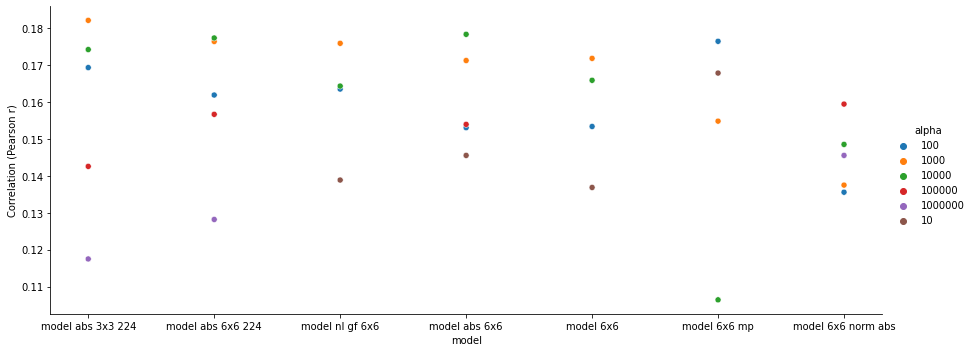

In [25]:
dataset = 'naturalscenes'
region = 'V4'
mode = 'cv'

data_dict = {                  


        'model abs 6x6 224':{
                'iden':'model_abs_6x6_224',
                #'model':EngModel3LAbsGF(filters_3=10000).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessRGB, 
                'num_layers':3,
                'num_features':10000,
                'pca':False,
                #'pca_dataset':'nsd',
                'num_pca_components':None,
                #'max_pca_components':5000,
                'pca_type':None,
                'max_pool':False,
                'alphas': [10**i for i in range(2,7)]}, 

    'model nl gf 6x6':{
                'iden':'model_abs_6x6_nl_gf',
                #'model':EngModel3LAbsGF(filters_3=10000).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=96).PreprocessGS, 
                'num_layers':3,
                'num_features':10000,
                'pca':False,
                #'pca_dataset':'nsd',
                'num_pca_components':None,
                #'max_pca_components':5000,
                'pca_type':None,
                'max_pool':False,
                'alphas': [10**i for i in range(1,5)]}, 
    
    'model abs 6x6':{
                'iden':'model_abs_6x6',
                #'model':EngModel3LAbsGF(filters_3=10000).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=96).PreprocessGS, 
                'num_layers':3,
                'num_features':10000,
                'pca':False,
                #'pca_dataset':'nsd',
                'num_pca_components':None,
                #'max_pca_components':5000,
                'pca_type':None,
                'max_pool':False,
                'alphas': [10**i for i in range(1,6)]}, 
    
    'model 6x6':{
                'iden':'model_6x6',
                #'model':EngModel3LAbsGF(filters_3=10000).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=96).PreprocessGS, 
                'num_layers':3,
                'num_features':10000,
                'pca':False,
                #'pca_dataset':'nsd',
                'num_pca_components':None,
                #'max_pca_components':5000,
                'pca_type':None,
                'max_pool':False,
                'alphas': [10**i for i in range(1,5)]}, 
    'model 6x6 mp':{
                'iden':'model_abs_6x6',
                #'model':EngModel3LAbsGF(filters_3=10000).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=96).PreprocessGS, 
                'num_layers':3,
                'num_features':10000,
                'pca':False,
                #'pca_dataset':'nsd',
                'num_pca_components':None,
                #'max_pca_components':5000,
                'pca_type':None,
                'max_pool':True,
                'alphas': [10**i for i in range(1,5)]}, 
    
    'model 6x6 norm abs':{
                'iden':'model_norm_abs_6x6',
                #'model':EngModel3LAbsGF(filters_3=10000).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=96).PreprocessGS, 
                'num_layers':3,
                'num_features':10000,
                'pca':False,
                #'pca_dataset':'nsd',
                'num_pca_components':None,
                #'max_pca_components':5000,
                'pca_type':None,
                'max_pool':False,
                'alphas': [10**i for i in range(2,7)]}, }

plot_data_means_by_model(data_dict, dataset, region, mode, file_name=None, show_legend=False)

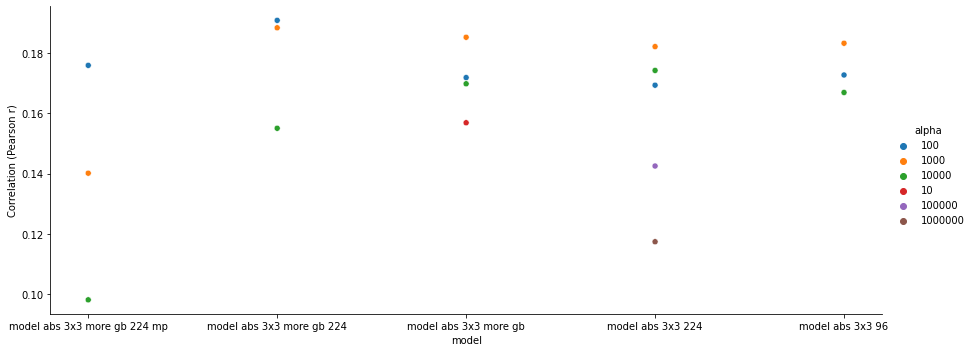

In [16]:
dataset = 'naturalscenes'
region = 'V4'
mode = 'cv'

data_dict = {                  
    
    
    
        'model abs 3x3 more gb 224 mp':{
                'iden':'model_abs_3x3_bp_224',
                #'model':EngModel3LAbsBP(filters_3=10000).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessGS, 
                'num_layers':3,
                'num_features':10000,
                'pca':False,
                #'pca_dataset':'nsd',
                'num_pca_components':None,
                #'max_pca_components':5000,
                'pca_type':None,
                'max_pool':True,
                'alphas': [10**i for i in range(2,5)]}, 

        'model abs 3x3 more gb 224':{
                'iden':'model_abs_3x3_bp_224',
                #'model':EngModel3LAbsBP(filters_3=10000).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessGS, 
                'num_layers':3,
                'num_features':10000,
                'pca':False,
                #'pca_dataset':'nsd',
                'num_pca_components':None,
                #'max_pca_components':5000,
                'pca_type':None,
                'max_pool':False,
                'alphas': [10**i for i in range(2,5)]}, 
    

    'model abs 3x3 more gb':{
                'iden':'model_abs_3x3_more_ori',
                #'model':EngModel3LAbsGF(filters_3=10000).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=96).PreprocessGS, 
                'num_layers':3,
                'num_features':10000,
                'pca':False,
                #'pca_dataset':'nsd',
                'num_pca_components':None,
                #'max_pca_components':5000,
                'pca_type':None,
                'max_pool':False,
                'alphas': [10**i for i in range(1,5)]}, 
    
    'model abs 3x3 224':{
                'iden':'model_abs_3x3_224',
                #'model':EngModel3LAbsGF(filters_3=10000).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessRGB, 
                'num_layers':3,
                'num_features':10000,
                'pca':False,
                #'pca_dataset':'nsd',
                'num_pca_components':None,
                #'max_pca_components':5000,
                'pca_type':None,
                'max_pool':False,
                'alphas': [10**i for i in range(2,7)]}, 
    
    'model abs 3x3 96':{
                'iden':'model_abs_3x3',
                #'model':EngModel3LAbsGF(filters_3=10000).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessRGB, 
                'num_layers':3,
                'num_features':10000,
                'pca':False,
                #'pca_dataset':'nsd',
                'num_pca_components':None,
                #'max_pca_components':5000,
                'pca_type':None,
                'max_pool':False,
                'alphas': [10**i for i in range(2,5)]}, 

            # 'model abs mp':{
            #     'iden':'model_abs_3x3',
            #     #'model':EngModel3LAbsGF(filters_3=10000).Build(),
            #     'layers': ['last'], 
            #     'preprocess':Preprocess(im_size=224).PreprocessRGB, 
            #     'num_layers':3,
            #     'num_features':10000,
            #     'pca':False,
            #     #'pca_dataset':'nsd',
            #     'num_pca_components':None,
            #     #'max_pca_components':5000,
            #     'pca_type':None,
            #     'max_pool':True,
            #     'alphas': [10**i for i in range(2,5)]}, 
    

}

plot_data_means_by_model(data_dict, dataset, region, mode, file_name=None, show_legend=False)

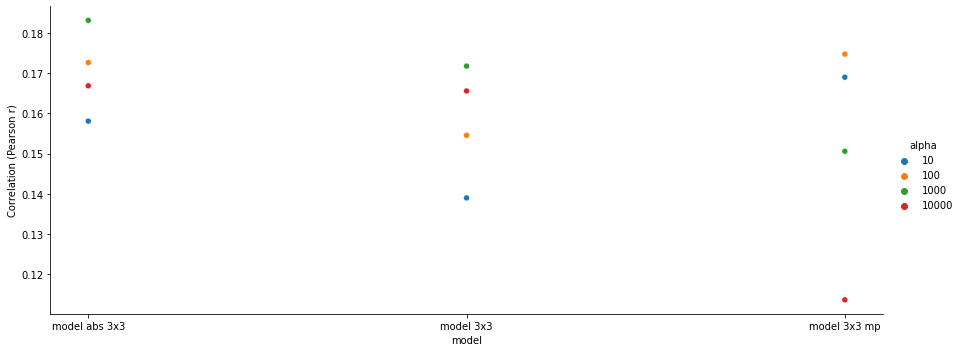

In [69]:
dataset = 'naturalscenes'
region = 'V4'
mode = 'cv'

data_dict = {                  

    'model abs 3x3':{
                'iden':'model_abs_3x3',
                #'model':EngModel3LAbsGF(filters_3=10000).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=96).PreprocessGS, 
                'num_layers':3,
                'num_features':10000,
                'pca':False,
                #'pca_dataset':'nsd',
                'num_pca_components':None,
                #'max_pca_components':5000,
                'pca_type':None,
                'max_pool':False,
                'alphas': [10**i for i in range(1,5)]},     

    'model 3x3':{
                'iden':'model_3x3',
                #'model':EngModel3LAbsGF(filters_3=10000).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=96).PreprocessGS, 
                'num_layers':3,
                'num_features':10000,
                'pca':False,
                #'pca_dataset':'nsd',
                'num_pca_components':None,
                #'max_pca_components':5000,
                'pca_type':None,
                'max_pool':False,
                'alphas': [10**i for i in range(1,5)]},     

    
#     'model abs 3x3 mp':{
#                 'iden':'model_abs_3x3',
#                 #'model':EngModel3LAbsGF(filters_3=10000).Build(),
#                 'layers': ['last'], 
#                 'preprocess':Preprocess(im_size=96).PreprocessGS, 
#                 'num_layers':3,
#                 'num_features':10000,
#                 'pca':False,
#                 #'pca_dataset':'nsd',
#                 'num_pca_components':None,
#                 #'max_pca_components':5000,
#                 'pca_type':None,
#                 'max_pool':True,
#                 'alphas': [10**i for i in range(1,6)]}, 
    

    'model 3x3 mp':{
                'iden':'model_3x3',
                #'model':EngModel3LAbsGF(filters_3=10000).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=96).PreprocessGS, 
                'num_layers':3,
                'num_features':10000,
                'pca':False,
                #'pca_dataset':'nsd',
                'num_pca_components':None,
                #'max_pca_components':5000,
                'pca_type':None,
                'max_pool':True,
                'alphas': [10**i for i in range(1,5)]}, 
}      
plot_data_means_by_model(data_dict, dataset, region, mode, file_name=None, show_legend=False)

In [67]:
xr.open_dataset('/data/atlas/activations/model_abs_3x3_mp_3_layers_10000_features_naturalscenes')

<xarray.Dataset>
Dimensions:      (features: 10000, presentation: 872)
Coordinates:
    stimulus_id  (presentation) object ...
Dimensions without coordinates: features, presentation
Data variables:
    x            (presentation, features) float32 ...

# Plot Models by Number of dims

## features

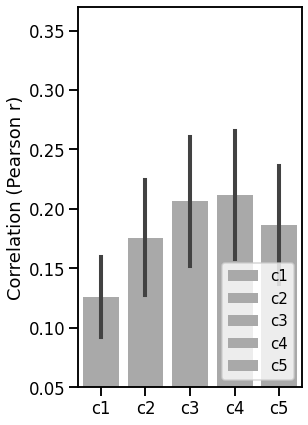

In [148]:
dataset = 'naturalscenes'
regions = ['V1','V2','V3','V4']
#regions = ['general']
# dataset = 'majajhong'
# regions = ['V4']

mode = 'test'
MAX_POOL = True

baseline_dict = {        
        
        
#        'alexnet conv1':{
#                 'iden':'alexnet_conv1',
#                 #'model':Alexnet(features_layer =2, global_mp = MAX_POOL).Build(),
#                 'layers': ['last'], 
#                 'preprocess':Preprocess(im_size=224).PreprocessRGB, 
#                 'num_layers':1,
#                 'num_features':64,
#                 'dim_reduction_type':None,
#                 'max_pool':MAX_POOL,
#                 'n_dims': None,
#                 'alphas': 'alexnet_mp'},            
    
#        'alexnet conv2':{
#                 'iden':'alexnet_conv2',
#                 #'model':Alexnet(features_layer =5, global_mp = MAX_POOL).Build(),
#                 'layers': ['last'], 
#                 'preprocess':Preprocess(im_size=224).PreprocessRGB, 
#                 'num_layers':2,
#                 'num_features':192,
#                 'dim_reduction_type':None,
#                 'max_pool':MAX_POOL,
#                 'n_dims': None,
#                 'alphas': 'alexnet_mp'},      
    
#        'alexnet conv3':{
#                 'iden':'alexnet_conv3',
#                 #'model':Alexnet(features_layer =7, global_mp = MAX_POOL).Build(),
#                 'layers': ['last'], 
#                 'preprocess':Preprocess(im_size=224).PreprocessRGB, 
#                 'num_layers':3,
#                 'num_features':384,
#                 'dim_reduction_type':None,
#                 'n_dims': None,
#                 'max_pool':MAX_POOL,
#                 'alphas': 'alexnet_mp'},    
    
#        'alexnet conv4':{
#                 'iden':'alexnet_conv4',
#                #'model':Alexnet(features_layer =9, global_mp = MAX_POOL).Build(),
#                 'layers': ['last'], 
#                 'preprocess':Preprocess(im_size=224).PreprocessRGB, 
#                 'num_layers':4,
#                 'n_dims': None,
#                 'num_features':256,
#                 'dim_reduction_type':None,
#                 'max_pool':MAX_POOL,
#                 'alphas': 'alexnet_mp'},     
        
#        'alexnet':{
#                 'iden':'alexnet',
#                #'model':Alexnet(global_mp = MAX_POOL).Build(),
#                 'layers': ['last'], 
#                 'preprocess':Preprocess(im_size=224).PreprocessRGB, 
#                 'num_layers':5,
#                 'n_dims': None,
#                 'num_features':256,
#                 'dim_reduction_type':None,
#                 'max_pool':MAX_POOL,
#                 'alphas': 'alexnet_mp'},    
    
       'alexnet u conv1':{
                'iden':'alexnet_u_conv1',
                #'model':AlexnetU(features_layer =2, global_mp = MAX_POOL).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessRGB, 
                'num_layers':1,
                'num_features':64,
                'n_dims': None,
                'dim_reduction_type':None,
                'max_pool':MAX_POOL,
                'alphas': 'alexnet_u_mp'},   
       
        'alexnet u conv2':{
                'iden':'alexnet_u_conv2',
                #'model':AlexnetU(features_layer =5, global_mp = MAX_POOL).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessRGB, 
                'num_layers':2,
                'num_features':192,
                'dim_reduction_type':None,
                'n_dims': None,
                'max_pool':MAX_POOL,
                'alphas': 'alexnet_u_mp'},   
       
        'alexnet u conv3':{
                'iden':'alexnet_u_conv3',
                #'model':AlexnetU(features_layer =7, global_mp = MAX_POOL).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessRGB, 
                'num_layers':3,
                'num_features':384,
                'dim_reduction_type':None,
                'max_pool':MAX_POOL,
                'n_dims': None,
                'alphas': 'alexnet_u_mp'},   
       
        'alexnet u conv4':{
                'iden':'alexnet_u_conv4',
                #'model':AlexnetU(features_layer =9, global_mp = MAX_POOL).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessRGB, 
                'num_layers':4,
                'num_features':256,
                'dim_reduction_type':None,
                'n_dims': None,
                'max_pool':MAX_POOL,
                'alphas': 'alexnet_u_mp'},       
        
        'alexnet u':{
                'iden':'alexnet_u',
                #'model':AlexnetU(global_mp = MAX_POOL).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessRGB, 
                'num_layers':5,
                'num_features':256,
                'dim_reduction_type':None,
                'max_pool':MAX_POOL,
                'n_dims': None,
                'alphas': 'alexnet_u_mp'},     
}



name_dict  = {
       # 'alexnet_conv1':'conv1',            
       # 'alexnet_conv2':'conv2', 
       # 'alexnet_conv3':'conv3',   
       # 'alexnet_conv4':'conv4', 
       # 'alexnet':'conv5', 
   
    
       'alexnet_u_conv1':'c1',   
       'alexnet_u_conv2':'c2',
       'alexnet_u_conv3':'c3',   
       'alexnet_u_conv4':'c4',
       'alexnet_u':'c5', 
}

baseline_palette = {         
       'c1':'darkgray',   
       'c2':'darkgray',
       'c3':'darkgray',   
       'c4':'darkgray',
       'c5':'darkgray', 
}

plt.clf()

plot_baselines(dataset, regions, mode,  aspect=1, height=6, ylim=(0.05,0.37), show_legend= True, width = 0.8,
                                params = (4,7), baseline_dict = baseline_dict, baseline_palette = baseline_palette,
                                name_dict= name_dict, file_name='alexnet u')


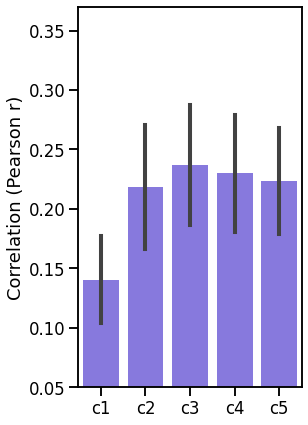

In [146]:
dataset = 'naturalscenes'
regions = ['V1','V2','V3','V4']
#regions = ['general']
# dataset = 'majajhong'
# regions = ['V4']

mode = 'test'
MAX_POOL = True

baseline_dict = {        
        
        
       'alexnet conv1':{
                'iden':'alexnet_conv1',
                #'model':Alexnet(features_layer =2, global_mp = MAX_POOL).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessRGB, 
                'num_layers':1,
                'num_features':64,
                'dim_reduction_type':None,
                'max_pool':MAX_POOL,
                'n_dims': None,
                'alphas': 'alexnet_mp'},            
    
       'alexnet conv2':{
                'iden':'alexnet_conv2',
                #'model':Alexnet(features_layer =5, global_mp = MAX_POOL).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessRGB, 
                'num_layers':2,
                'num_features':192,
                'dim_reduction_type':None,
                'max_pool':MAX_POOL,
                'n_dims': None,
                'alphas': 'alexnet_mp'},      
    
       'alexnet conv3':{
                'iden':'alexnet_conv3',
                #'model':Alexnet(features_layer =7, global_mp = MAX_POOL).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessRGB, 
                'num_layers':3,
                'num_features':384,
                'dim_reduction_type':None,
                'n_dims': None,
                'max_pool':MAX_POOL,
                'alphas': 'alexnet_mp'},    
    
       'alexnet conv4':{
                'iden':'alexnet_conv4',
               #'model':Alexnet(features_layer =9, global_mp = MAX_POOL).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessRGB, 
                'num_layers':4,
                'n_dims': None,
                'num_features':256,
                'dim_reduction_type':None,
                'max_pool':MAX_POOL,
                'alphas': 'alexnet_mp'},     
        
       'alexnet':{
                'iden':'alexnet',
               #'model':Alexnet(global_mp = MAX_POOL).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessRGB, 
                'num_layers':5,
                'n_dims': None,
                'num_features':256,
                'dim_reduction_type':None,
                'max_pool':MAX_POOL,
                'alphas': 'alexnet_mp'},    
  
}



name_dict  = {
       'alexnet_conv1':'c1',            
       'alexnet_conv2':'c2', 
       'alexnet_conv3':'c3',   
       'alexnet_conv4':'c4', 
       'alexnet':'c5', 
   

}

baseline_palette = {         
       'c1':'mediumslateblue',   
       'c2':'mediumslateblue',
       'c3':'mediumslateblue',   
       'c4':'mediumslateblue',
       'c5':'mediumslateblue', 
}

plt.clf()

plot_baselines(dataset, regions, mode,  aspect=1, height=6, ylim=(0.05,0.37), show_legend= False, width = 0.8,
                                params = (4,7), baseline_dict = baseline_dict, baseline_palette = baseline_palette,
                                name_dict= name_dict, file_name='alexnet')


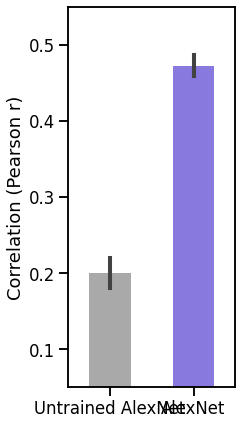

In [27]:
# dataset = 'naturalscenes'
# regions = ['V1','V2','V3','V4']
#regions = ['general']
dataset = 'majajhong'
regions = ['IT']

mode = 'test'
MAX_POOL = True

baseline_dict = {        
        
        
        
       'alexnet u':{
                'iden':'alexnet_u',
               #'model':Alexnet(global_mp = MAX_POOL).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessRGB, 
                'num_layers':5,
                'n_dims': None,
                'num_features':256,
                'dim_reduction_type':None,
                'max_pool':MAX_POOL,
                'alphas': 'alexnet_u_mp'},  
    
        
       'alexnet':{
                'iden':'alexnet',
               #'model':Alexnet(global_mp = MAX_POOL).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessRGB, 
                'num_layers':5,
                'n_dims': None,
                'num_features':256,
                'dim_reduction_type':None,
                'max_pool':MAX_POOL,
                'alphas': 'alexnet_mp'},    
  
}



name_dict  = {
       'alexnet':'AlexNet',            
       'alexnet_u':'Untrained AlexNet', 
   

}

baseline_palette = {         
       'AlexNet':'mediumslateblue',   
       'Untrained AlexNet':'darkgray',

}

plt.clf()

plot_baselines(dataset, regions, mode,  aspect=1, height=6, ylim=(0.05,0.55), show_legend= False, width = 0.5,
                                params = (3,7), baseline_dict = baseline_dict, baseline_palette = baseline_palette,
                                name_dict= name_dict, file_name=f'alexnet {regions}')


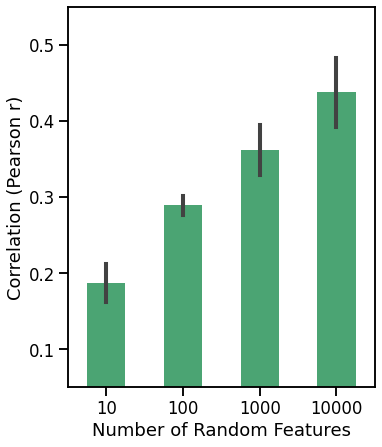

In [19]:
# dataset = 'naturalscenes'
# regions = ['V1','V2','V3','V4']
# regions = ['general']
dataset = 'majajhong'
regions = ['IT']

mode = 'test'
MAX_POOL = True
data_dict = {  
        'model abs 3x3 bp 224 10 filters':{
                'iden':'model_abs_3x3_bp_224',
                #'model':EngModel3LAbsBP(filters_3 = 10, global_mp = MAX_POOL).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessGS, 
                'num_layers':3,
                'num_features':10,
                'dim_reduction_type':None,
                'n_dims': None,
                'max_pool':MAX_POOL,
                'alphas': 'model_abs_3x3_bp_224_mp'},  
    
    'model abs 3x3 bp 224 100 filters':{
                'iden':'model_abs_3x3_bp_224',
                #'model':EngModel3LAbsBP(filters_3 = 100, global_mp = MAX_POOL).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessGS, 
                'num_layers':3,
                'num_features':100,
                'dim_reduction_type':None,
                'n_dims': None,
                'max_pool':MAX_POOL,
                'alphas': 'model_abs_3x3_bp_224_mp'},  
    
    'model abs 3x3 bp 224 1000 filters':{
                'iden':'model_abs_3x3_bp_224',
                #'model':EngModel3LAbsBP(filters_3 = 1000, global_mp = MAX_POOL).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessGS, 
                'num_layers':3,
                'num_features':1000,
                'dim_reduction_type':None,
                'n_dims': None,
                'max_pool':MAX_POOL,
                'alphas': 'model_abs_3x3_bp_224_mp'},  
    
    'model abs 3x3 bp 224 10000 filters':{
                'iden':'model_abs_3x3_bp_224',
                #'model':EngModel3LAbsBP(filters_3 = 10000, global_mp = MAX_POOL).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessGS, 
                'num_layers':3,
                'num_features':10000,
                'dim_reduction_type':None,
                'max_pool':MAX_POOL,
                'n_dims': None,
                'alphas': 'model_abs_3x3_bp_224_mp'},  

    
#         'model abs 3x3 bp 224 ap 10 filters':{
#                 'iden':'model_abs_3x3_bp_224_ap',
#                 #'model':EngModel3LAbsBPAP(filters_3 = 10, global_mp = MAX_POOL).Build(),
#                 'layers': ['last'], 
#                 'preprocess':Preprocess(im_size=224).PreprocessGS, 
#                 'num_layers':3,
#                 'num_features':10,
#                 'dim_reduction_type':None,
#                 'max_pool':MAX_POOL,
#                 'n_dims': None,
#                 'alphas': 'model_abs_3x3_bp_224_ap_mp'},  

#         'model abs 3x3 bp 224 ap 100 filters':{
#                 'iden':'model_abs_3x3_bp_224_ap',
#                 #'model':EngModel3LAbsBPAP(filters_3 = 100, global_mp = MAX_POOL).Build(),
#                 'layers': ['last'], 
#                 'preprocess':Preprocess(im_size=224).PreprocessGS, 
#                 'num_layers':3,
#                 'num_features':100,
#                 'dim_reduction_type':None,
#                 'max_pool':MAX_POOL,
#                 'n_dims': None,
#                 'alphas': 'model_abs_3x3_bp_224_ap_mp'},  
    
#         'model abs 3x3 bp 224 ap 1000 filters':{
#                 'iden':'model_abs_3x3_bp_224_ap',
#                 #'model':EngModel3LAbsBPAP(filters_3 = 1000, global_mp = MAX_POOL).Build(),
#                 'layers': ['last'], 
#                 'preprocess':Preprocess(im_size=224).PreprocessGS, 
#                 'num_layers':3,
#                 'num_features':1000,
#                 'dim_reduction_type':None,
#                 'max_pool':MAX_POOL,
#                 'n_dims': None,
#                 'alphas': 'model_abs_3x3_bp_224_ap_mp'},  
    

#         'model abs 3x3 bp 224 ap 10000 filters':{
#                 'iden':'model_abs_3x3_bp_224_ap',
#                 #'model':EngModel3LAbsBPAP(filters_3 = 1000, global_mp = MAX_POOL).Build(),
#                 'layers': ['last'], 
#                 'preprocess':Preprocess(im_size=224).PreprocessGS, 
#                 'num_layers':3,
#                 'num_features':10000,
#                 'dim_reduction_type':None,
#                 'max_pool':MAX_POOL,
#                 'n_dims': None,
#                 'alphas': 'model_abs_3x3_bp_224_ap_mp'},  
    
  
    
    
#        'alexnet u wide 10 filters':{
#                 'iden':'alexnet_u_wide',
#                 #'model':AlexnetUWide(filters_5 = 10, global_mp = MAX_POOL).Build(),
#                 'layers': ['last'], 
#                 'preprocess':Preprocess(im_size=224).PreprocessRGB, 
#                 'num_layers':5,
#                 'num_features':10,
#                 'dim_reduction_type':None,
#                  'max_pool':MAX_POOL,
#                 'n_dims': None,
#                'alphas': 'alexnet_u_wide_mp'},  
        
    
         
#        'alexnet u wide 100 filters':{
#                 'iden':'alexnet_u_wide',
#                 #'model':AlexnetUWide(filters_5 = 100, global_mp = MAX_POOL).Build(),
#                 'layers': ['last'], 
#                 'preprocess':Preprocess(im_size=224).PreprocessRGB, 
#                 'num_layers':5,
#                 'num_features':100,
#                 'dim_reduction_type':None,
#                 'max_pool':MAX_POOL,
#                 'n_dims': None,
#                'alphas': 'alexnet_u_wide_mp'},     
    
    
#        'alexnet u wide 1000 filters':{
#                 'iden':'alexnet_u_wide',
#                 #'model':AlexnetUWide(filters_5 = 1000, global_mp = MAX_POOL).Build(),
#                 'layers': ['last'], 
#                 'preprocess':Preprocess(im_size=224).PreprocessRGB, 
#                 'num_layers':5,
#                 'num_features':1000,
#                 'dim_reduction_type':None,
#                 'max_pool':MAX_POOL,
#                 'n_dims': None,
#                'alphas': 'alexnet_u_wide_mp'},  

    
    
#        'alexnet u wide 10000 filters':{
#                 'iden':'alexnet_u_wide',
#                 #'model':AlexnetUWide(filters_5 = 10000, global_mp = MAX_POOL).Build(),
#                 'layers': ['last'], 
#                 'preprocess':Preprocess(im_size=224).PreprocessRGB, 
#                 'num_layers':5,
#                 'num_features':10000,
#                 'dim_reduction_type':None,
#                  'max_pool':MAX_POOL,
#                 'n_dims': None,
#                'alphas':'alexnet_u_wide_mp'},   
            
}   

baseline_dict = {        
        
#     'alexnet':{
#                 'iden':'alexnet',
#                 #'model':Alexnet(global_mp = MAX_POOL).Build(),
#                 'layers': ['last'], 
#                 'preprocess':Preprocess(im_size=224).PreprocessRGB, 
#                 'num_layers':5,
#                 'num_features':256,
#                 'dim_reduction_type':None,
#                 'n_dims': None,
#                 'max_pool':MAX_POOL,
#                 'alphas': 'alexnet_mp'},            
    
    
#        'alexnet u':{
#                 'iden':'alexnet_u',
#                 #'model':AlexnetU(global_mp = MAX_POOL).Build(),
#                 'layers': ['last'], 
#                 'preprocess':Preprocess(im_size=224).PreprocessRGB, 
#                 'num_layers':5,
#                 'num_features':256,
#                 'dim_reduction_type':None,
#                 'n_dims': None,
#                 'max_pool':MAX_POOL,
#                 'alphas': 'alexnet_u_mp'}, 
        
    # 'scattering transform kymatio':{
    #             'iden':'scat_transform_kymatio_J3_L4_rgb',
    #             #'model':ScatTransformKymatio(J = 3, L = 8, M = 32, N = 32, flatten = True, global_mp= False).Build(),
    #             'layers': ['last'], 
    #             'preprocess':Preprocess(im_size=32).PreprocessRGB, 
    #             'num_layers':2,
    #             'num_features':'x',
    #             'dim_reduction_type':None,
    #             'n_dims': None,
    #             'max_pool':False,
    #             'alphas': 'scat_transform_kymatio_J3_L4_rgb'},
    

}


name_dict = {#'model_abs_3x3_bp_224_ap':'Expansion Model',
             'model_abs_3x3_bp_224':'Expansion Model',
#             'scat_transform_kymatio_J3_L8':'Scattering Transform',
#             'alexnet_u_wide':'Untrained Wide AlexNet',
#             'alexnet_u':'Untrained AlexNet',
#             'alexnet': 'AlexNet'
            }


palette = {'Expansion Model':'mediumseagreen',
#            'Untrained Wide AlexNet':'steelblue'
          }

baseline_palette = ['firebrick','orange','purple']

plot_data_means_vs_features(data_dict, dataset, regions, mode, baseline_dict  = None,
                            name_dict = name_dict, palette= palette, baseline_palette = None,
                            error_bars = False, ylim = (0.05, 0.55), width=0.5,show_legend = False,
                            params= (5.5,7), xlog = False, x_axis = 'num_features', 
                            file_name =  f'{regions} - {dataset} - eng models xlog')

In [ ]:
df_baseline = get_data(baseline_dict, dataset, regions, mode, subjects = [i for i in range(8)])

for i in df['iden'].unique():
#for index, row in df_baseline.iterrows():
    df_model = df_baseline[df_baseline["iden"] == i]

In [154]:
pd.DataFrame(df_baseline.to_records()).columns

Index(['index', '('iden', '')', '('score', 'mean')', '('score', 'std')'], dtype='object')

## pca

### np max pool

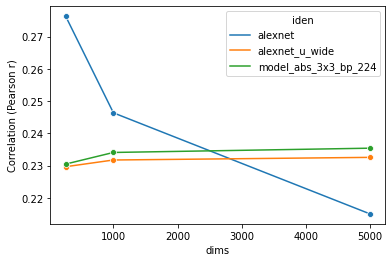

In [15]:
dataset = 'naturalscenes'
region = 'V4'
mode = 'test'
MAX_POOL = False

data_dict = {                  
        
            'alexnet 256 pcs':{
                'iden':'alexnet',
                'layers': ['pca5'], 
                'preprocess':Preprocess(im_size=224).PreprocessRGB, 
                'num_layers':5,
                'num_features':256,
                'pca':True,
                'pca_dataset':'nsd',
                'n_dims':256,
                'max_dims':5000,
                'dim_reduction_type':'pca',
                'max_pool':MAX_POOL,
                'alphas': 'alexnet_pca'}, 
    
            'alexnet 1000 pcs':{
                'iden':'alexnet',
                'layers': ['pca5'], 
                'preprocess':Preprocess(im_size=224).PreprocessRGB, 
                'num_layers':5,
                'num_features':256,
                'pca':True,
                'pca_dataset':'nsd',
                'n_dims':1000,
                'max_dims':5000,
                'dim_reduction_type':'pca',
                'max_pool':MAX_POOL,
                'alphas': 'alexnet_pca'}, 

    
            'alexnet 5000 pcs':{
                'iden':'alexnet',
                'layers': ['pca5'], 
                'preprocess':Preprocess(im_size=224).PreprocessRGB, 
                'num_layers':5,
                'num_features':256,
                'pca':True,
                'pca_dataset':'nsd',
                'n_dims':5000,
                'max_dims':5000,
                'dim_reduction_type':'pca',
                'max_pool':MAX_POOL,
                'alphas': 'alexnet_pca'},   
    
            'alexnet u wide 256 pcs':{
                'iden':'alexnet_u_wide',
                'layers': ['pca5'], 
                'preprocess':Preprocess(im_size=224).PreprocessRGB, 
                'num_layers':5,
                'num_features':10000,
                'pca':True,
                'pca_dataset':'nsd',
                'n_dims':256,
                'max_dims':5000,
                'dim_reduction_type':'pca',
                'max_pool':MAX_POOL,
                'alphas': 'alexnet_u_wide_pca'}, 
    
            'alexnet u wide 1000 pcs':{
                'iden':'alexnet_u_wide',
                'layers': ['pca5'], 
                'preprocess':Preprocess(im_size=224).PreprocessRGB, 
                'num_layers':5,
                'num_features':10000,
                'pca':True,
                'pca_dataset':'nsd',
                'n_dims':1000,
                'max_dims':5000,
                'dim_reduction_type':'pca',
                'max_pool':MAX_POOL,
                'alphas': 'alexnet_u_wide_pca'}, 

    
            'alexnet u wide 5000 pcs':{
                'iden':'alexnet_u_wide',
                'layers': ['pca5'], 
                'preprocess':Preprocess(im_size=224).PreprocessRGB, 
                'num_layers':5,
                'num_features':10000,
                'pca':True,
                'pca_dataset':'nsd',
                'n_dims':5000,
                'max_dims':5000,
                'dim_reduction_type':'pca',
                'max_pool':MAX_POOL,
                'alphas': 'alexnet_u_wide_pca'},   

        
    
    
                 'model abs 3x3 bp 224 256 pcs':{
                'iden':'model_abs_3x3_bp_224',
                #'model':EngModel3LAbsBPPCA(filters_3=10000,n_components=5000).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessGS, 
                'num_layers':3,
                'num_features':10000,
                'pca':True,
                'pca_dataset':'nsd',
                'n_dims':256,
                'max_dims':5000,
                'dim_reduction_type':'pca',
                'max_pool':MAX_POOL,
                'alphas': 'model_abs_3x3_bp_224'}, 
    
    
                    
                 'model abs 3x3 bp 224 1000 pcs':{
                'iden':'model_abs_3x3_bp_224',
                #'model':EngModel3LAbsBPPCA(filters_3=10000,n_components=5000).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessGS, 
                'num_layers':3,
                'num_features':10000,
                'pca':True,
                'pca_dataset':'nsd',
                'n_dims':1000,
                'max_dims':5000,
                'dim_reduction_type':'pca',
                'max_pool':MAX_POOL,
                'alphas': 'model_abs_3x3_bp_224'}, 

    
                'model abs 3x3 bp 224 5000 pcs':{
                'iden':'model_abs_3x3_bp_224',
                #'model':EngModel3LAbsBPPCA(filters_3=10000,n_components=5000).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessGS, 
                'num_layers':3,
                'num_features':10000,
                'pca':True,
                'pca_dataset':'nsd',
                'n_dims':5000,
                'max_dims':5000,
                'dim_reduction_type':'pca',
                'max_pool':MAX_POOL,
                'alphas': 'model_abs_3x3_bp_224'}, 

}

plot_data_means_vs_features(data_dict, dataset, region, mode, file_name =' pca no max pool', show_legend=False)

### max pool

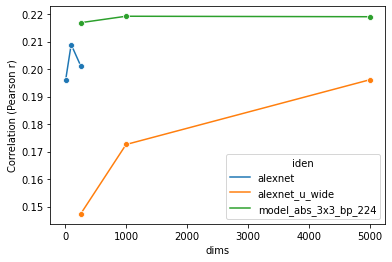

In [10]:
dataset = 'naturalscenes'
region = 'V4'
mode = 'test'
MAX_POOL = True
data_dict = {  
        'alexnet 10 pcs':{
                'iden':'alexnet',
                #'model':AlexnetPCA(n_components=256, global_mp = MAX_POOL).Build(),
                'layers': ['pca5'], 
                'preprocess':Preprocess(im_size=224).PreprocessRGB, 
                'num_layers':5,
                'num_features':256,
                'pca_dataset':'nsd',
                'n_dims':10,
                'max_dims':256,
                'dim_reduction_type':'pca',
                'max_pool':MAX_POOL,
                'alphas': 'alexnet_mp_pca'}, 

        'alexnet 100 pcs':{
                'iden':'alexnet',
                #'model':AlexnetPCA(n_components=256, global_mp = MAX_POOL).Build(),
                'layers': ['pca5'], 
                'preprocess':Preprocess(im_size=224).PreprocessRGB, 
                'num_layers':5,
                'num_features':256,
                'pca_dataset':'nsd',
                'n_dims':100,
                'max_dims':256,
                'dim_reduction_type':'pca',
                'max_pool':MAX_POOL,
                'alphas': 'alexnet_mp_pca'}, 
    
        'alexnet 256 pcs':{
                'iden':'alexnet',
                #'model':AlexnetPCA(n_components=256, global_mp = MAX_POOL).Build(),
                'layers': ['pca5'], 
                'preprocess':Preprocess(im_size=224).PreprocessRGB, 
                'num_layers':5,
                'num_features':256,
                'pca_dataset':'nsd',
                'n_dims':256,
                'max_dims':256,
                'dim_reduction_type':'pca',
                'max_pool':MAX_POOL,
                'alphas': 'alexnet_mp_pca'}, 
    
        'alexnet u wide 256 pcs':{
                'iden':'alexnet_u_wide',
                #'model':AlexnetUPCA(n_components=5000, global_mp = MAX_POOL).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessRGB, 
                'num_layers':5,
                'num_features':10000,
                'pca_dataset':'nsd',
                'n_dims':256,
                'max_dims':5000,
                'dim_reduction_type':'pca',
                'max_pool':MAX_POOL,
                'alphas': 'alexnet_u_wide_mp_pca'}, 

        'alexnet u wide 1000 pcs':{
                'iden':'alexnet_u_wide',
                #'model':AlexnetUPCA(n_components=5000, global_mp = MAX_POOL).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessRGB, 
                'num_layers':5,
                'num_features':10000,
                'pca_dataset':'nsd',
                'n_dims':1000,
                'max_dims':5000,
                'dim_reduction_type':'pca',
                'max_pool':MAX_POOL,
                'alphas': 'alexnet_u_wide_mp_pca'},     
        
         
        'alexnet u wide 5000 pcs':{
                'iden':'alexnet_u_wide',
                #'model':AlexnetUPCA(n_components=5000, global_mp = MAX_POOL).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessRGB, 
                'num_layers':5,
                'num_features':10000,
                'pca_dataset':'nsd',
                'n_dims':5000,
                'max_dims':5000,
                'dim_reduction_type':'pca',
                'max_pool':MAX_POOL,
                'alphas': 'alexnet_u_wide_mp_pca'}, 
        
    'model abs 3x3 bp 224 256 pcs':{
                'iden':'model_abs_3x3_bp_224',
                #'model':EngModel3LAbsBPPCA(filters_3 = 10000, n_components=5000, global_mp = MAX_POOL).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessGS, 
                'num_layers':3,
                'num_features':10000,
                'pca_dataset':'nsd',
                'n_dims':256,
                'max_dims':5000,
                'dim_reduction_type':'pca',
                'max_pool':MAX_POOL,
                'alphas': 'model_abs_3x3_bp_224_mp_pca'}, 

        'model abs 3x3 bp 224 1000 pcs':{
                'iden':'model_abs_3x3_bp_224',
                #'model':EngModel3LAbsBPPCA(filters_3 = 10000, n_components=5000, global_mp = MAX_POOL).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessGS, 
                'num_layers':3,
                'num_features':10000,
                'pca_dataset':'nsd',
                'n_dims':1000,
                'max_dims':5000,
                'dim_reduction_type':'pca',
                'max_pool':MAX_POOL,
                'alphas': 'model_abs_3x3_bp_224_mp_pca'},   
        
         
        'model abs 3x3 bp 224 5000 pcs':{
                'iden':'model_abs_3x3_bp_224',
                #'model':EngModel3LAbsBPPCA(filters_3 = 10000, n_components=5000, global_mp = MAX_POOL).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessGS, 
                'num_layers':3,
                'num_features':10000,
                'pca_dataset':'nsd',
                'n_dims':5000,
                'max_dims':5000,
                'dim_reduction_type':'pca',
                'max_pool':MAX_POOL,
                'alphas': 'model_abs_3x3_bp_224_mp_pca'}, 
}   
    
plot_data_means_vs_features(data_dict, dataset, region, mode, file_name =  'pca max pool', show_legend=False)

## random projections

### no max pool

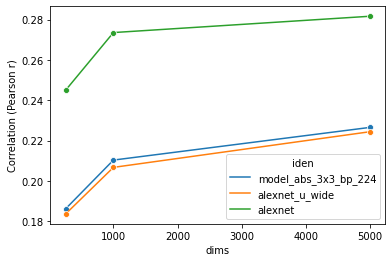

In [12]:
dataset = 'naturalscenes'
region = 'V4'
mode = 'test'
MAX_POOL = False
data_dict = {  
    'model abs 3x3 bp 224 256 rps':{
                'iden':'model_abs_3x3_bp_224',
                #'model':EngModel3LAbsBP(filters_3 = 10000, num_projections=5000, global_mp = MAX_POOL).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessGS, 
                'num_layers':3,
                'num_features':10000,
                'n_dims':256,
                'dim_reduction_type':'rp',
                'max_pool':MAX_POOL,
                'alphas': 'model_abs_3x3_bp_224_rp'},  

        'model abs 3x3 bp 224 1000 rps':{
                'iden':'model_abs_3x3_bp_224',
                #'model':EngModel3LAbsBP(filters_3 = 10000, num_projections=5000, global_mp = MAX_POOL).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessGS, 
                'num_layers':3,
                'num_features':10000,
                'n_dims':1000,
                'dim_reduction_type':'rp',
                'max_pool':MAX_POOL,
                'alphas': 'model_abs_3x3_bp_224_rp'},  
        
         
        'model abs 3x3 bp 224 5000 rps':{
                'iden':'model_abs_3x3_bp_224',
                #'model':EngModel3LAbsBP(filters_3 = 10000, num_projections=5000, global_mp = MAX_POOL).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessGS, 
                'num_layers':3,
                'num_features':10000,
                'n_dims':5000,
                'dim_reduction_type':'rp',
                'max_pool':MAX_POOL,
                'alphas': 'model_abs_3x3_bp_224_rp'}, 
    
    
            'alexnet u wide 256 rps':{
                'iden':'alexnet_u_wide',
                #'model':AlexnetU(filters_5 = 10000, num_projections=256, global_mp = MAX_POOL).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessRGB, 
                'num_layers':5,
                'num_features':10000,
                'dim_reduction_type':'rp',
                'max_pool':MAX_POOL,
                'n_dims':256,
                'alphas': 'alexnet_u_wide_rp'},  

    
    
       'alexnet u wide 1000 rps':{
                'iden':'alexnet_u_wide',
                #'model':AlexnetU(filters_5 = 10000, num_projections=1000, global_mp = MAX_POOL).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessRGB, 
                'num_layers':5,
                'num_features':10000,
                'dim_reduction_type':'rp',
                'max_pool':MAX_POOL,
                'n_dims':1000,
                'alphas': 'alexnet_u_wide_rp'},  
        
    
         
       'alexnet u wide 5000 rps':{
                'iden':'alexnet_u_wide',
                #'model':AlexnetU(filters_5 = 10000, num_projections=5000, global_mp = MAX_POOL).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessRGB, 
                'num_layers':5,
                'num_features':10000,
                'dim_reduction_type':'rp',
                'max_pool':MAX_POOL,
                'n_dims':5000,
                'alphas': 'alexnet_u_wide_rp'}, 

        'alexnet 256 rps':{
                'iden':'alexnet',
                #'model':Alexnet(num_projections=256, global_mp = MAX_POOL).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessRGB, 
                'num_layers':5,
                'num_features':256,
                'dim_reduction_type':'rp',
                'max_pool':MAX_POOL,
                'n_dims':256,
                'alphas': 'alexnet_rp'},  

    
    
        'alexnet 1000 rps':{
                'iden':'alexnet',
                #'model':Alexnet(num_projections=1000, global_mp = MAX_POOL).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessRGB, 
                'num_layers':5,
                'num_features':256,
                'dim_reduction_type':'rp',
                'max_pool':MAX_POOL,
                'n_dims':1000,
                'alphas': 'alexnet_rp'},    
        
    
         
        'alexnet 5000 rps':{
                'iden':'alexnet',
                #'model':Alexnet(num_projections=5000, global_mp = MAX_POOL).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessRGB, 
                'num_layers':5,
                'num_features':256,
                'dim_reduction_type':'rp',
                'max_pool':MAX_POOL,
                'n_dims':5000,
                'alphas': 'alexnet_rp'},
}   
    
plot_data_means_vs_features(data_dict, dataset, region, mode, file_name = 'random projections no max pool', show_legend=False)

### max pool

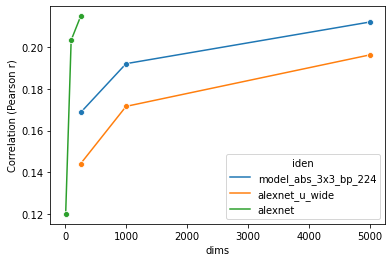

In [9]:
dataset = 'naturalscenes'
region = 'V4'
mode = 'test'
MAX_POOL = True
data_dict = { 
    'model abs 3x3 bp 224 256 rps':{
                'iden':'model_abs_3x3_bp_224',
                #'model':EngModel3LAbsBP(filters_3 = 10000, num_projections=256, global_mp = MAX_POOL).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessGS, 
                'num_layers':3,
                'num_features':10000,
                'dim_reduction_type':'rp',
                'max_pool':MAX_POOL,
                'n_dims':256,
                'max_dims':256,
                'alphas': 'model_abs_3x3_bp_224_mp_rp'},  

    
    
        'model abs 3x3 bp 224 1000 rps':{
                'iden':'model_abs_3x3_bp_224',
                #'model':EngModel3LAbsBP(filters_3 = 10000, num_projections=1000, global_mp = MAX_POOL).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessGS, 
                'num_layers':3,
                'num_features':10000,
                'dim_reduction_type':'rp',
                'max_pool':MAX_POOL,
                'n_dims':1000,
                'max_dims':1000,
                'alphas': 'model_abs_3x3_bp_224_mp_rp'},  
        
    
         
        'model abs 3x3 bp 224 5000 rps':{
                'iden':'model_abs_3x3_bp_224',
                #'model':EngModel3LAbsBP(filters_3 = 10000, num_projections=5000, global_mp = MAX_POOL).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessGS, 
                'num_layers':3,
                'num_features':10000,
                'dim_reduction_type':'rp',
                'max_pool': MAX_POOL,
                'n_dims':5000,
                'max_dims':5000,
                'alphas': 'model_abs_3x3_bp_224_mp_rp'},     

        'alexnet u wide 256 rps':{
                'iden':'alexnet_u_wide',
                #'model':AlexnetU(filters_5 = 10000, num_projections=256, global_mp = MAX_POOL).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessRGB, 
                'num_layers':5,
                'num_features':10000,
                'dim_reduction_type':'rp',
                'max_pool':MAX_POOL,
                'n_dims':256,
                'alphas': 'alexnet_u_wide_mp_rp'},  

    
    
       'alexnet u wide 1000 rps':{
                'iden':'alexnet_u_wide',
                #'model':AlexnetU(filters_5 = 10000, num_projections=1000, global_mp = MAX_POOL).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessRGB, 
                'num_layers':5,
                'num_features':10000,
                'dim_reduction_type':'rp',
                'max_pool':MAX_POOL,
                'n_dims':1000,
                'alphas': 'alexnet_u_wide_mp_rp'},  
        
    
         
        'alexnet u wide 5000 rps':{
                'iden':'alexnet_u_wide',
                #'model':AlexnetU(filters_5 = 10000, num_projections=256 global_mp = MAX_POOL).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessRGB, 
                'num_layers':5,
                'num_features':10000,
                'dim_reduction_type':'rp',
                'max_pool':MAX_POOL,
                'n_dims':5000,
                'alphas': 'alexnet_u_wide_mp_rp'},       
    
    
        'alexnet 10 rps':{
                'iden':'alexnet',
                #'model':Alexnet(num_projections=10, global_mp = MAX_POOL).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessRGB, 
                'num_layers':5,
                'num_features':256,
                'dim_reduction_type':'rp',
                'max_pool':MAX_POOL,
                'n_dims':10,
                'alphas': 'alexnet_mp_rp'},  

    
    
        'alexnet 100 rps':{
                'iden':'alexnet',
                #'model':Alexnet(num_projections=100, global_mp = MAX_POOL).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessRGB, 
                'num_layers':5,
                'num_features':256,
                'dim_reduction_type':'rp',
                'max_pool':MAX_POOL,
                'n_dims':100,
                'alphas': 'alexnet_mp_rp'},    
        
    
         
        'alexnet 256 rps':{
                'iden':'alexnet',
                #'model':Alexnet(num_projections=256, global_mp = MAX_POOL).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessRGB, 
                'num_layers':5,
                'num_features':256,
                'dim_reduction_type':'rp',
                'max_pool':MAX_POOL,
                'n_dims':256,
                'alphas': 'alexnet_mp_rp'},   
    }   
    
plot_data_means_vs_features(data_dict, dataset, region, mode, file_name = 'random projections maxpool', show_legend=False)

# Per subject analysis

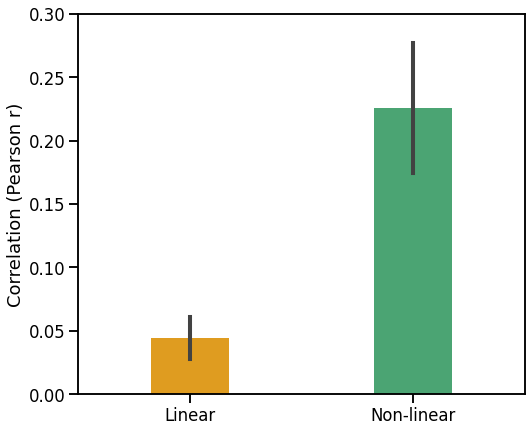

In [13]:
dataset = 'naturalscenes'
regions = ['V4']
#regions = ['general']
# dataset = 'majajhong'
# regions = ['V4']

mode = 'test'
MAX_POOL = True

dataset = 'naturalscenes'
regions = ['V4']
mode = 'test'
MAX_POOL = True

baseline_dict = {
    'model 3x3 bp 224 ap 10000 filters':{
                'iden':'model_3x3_bp_224_ap',
                #'model':EngModel3LAbsBPAP(filters_3 = 1000, global_mp = MAX_POOL).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessGS, 
                'num_layers':3,
                'num_features':10000,
                'dim_reduction_type':None,
                'max_pool':MAX_POOL,
                'n_dims': None,
                'alphas': 'model_3x3_bp_224_ap_mp'},   
    
    
    'model abs 3x3 bp 224 ap 10000 filters':{
                'iden':'model_abs_3x3_bp_224_ap',
                #'model':EngModel3LAbsBPAP(filters_3 = 1000, global_mp = MAX_POOL).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessGS, 
                'num_layers':3,
                'num_features':10000,
                'dim_reduction_type':None,
                'max_pool':MAX_POOL,
                'n_dims': None,
                'alphas': 'model_abs_3x3_bp_224_ap_mp'},  

}
        

name_dict =  {'model_3x3_bp_224_ap':'Linear',
             'model_abs_3x3_bp_224_ap':'Non-linear'}

baseline_palette = {'Non-linear':'mediumseagreen', 
           'Linear':'orange'}
plt.clf()
plot_baselines(dataset, regions, mode,  aspect = 0.5, height =6.5, show_legend= False, ylim = (0.0, 0.3),
                                params= (8,7), baseline_dict = baseline_dict, baseline_palette = baseline_palette,
                                name_dict= name_dict, file_name = 'linear vs non linear')

<Figure size 432x288 with 0 Axes>

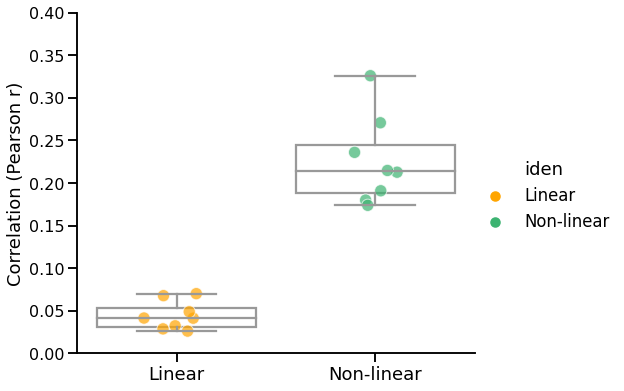

In [153]:
dataset = 'naturalscenes'
regions = ['V4']
mode = 'test'
MAX_POOL = True

data_dict = {
    'model 3x3 bp 224 ap 10000 filters':{
                'iden':'model_3x3_bp_224_ap',
                #'model':EngModel3LAbsBPAP(filters_3 = 1000, global_mp = MAX_POOL).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessGS, 
                'num_layers':3,
                'num_features':10000,
                'dim_reduction_type':None,
                'max_pool':MAX_POOL,
                'n_dims': None,
                'alphas': 'model_3x3_bp_224_ap_mp'},   
    
    
    'model abs 3x3 bp 224 ap 10000 filters':{
                'iden':'model_abs_3x3_bp_224_ap',
                #'model':EngModel3LAbsBPAP(filters_3 = 1000, global_mp = MAX_POOL).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessGS, 
                'num_layers':3,
                'num_features':10000,
                'dim_reduction_type':None,
                'max_pool':MAX_POOL,
                'n_dims': None,
                'alphas': 'model_abs_3x3_bp_224_ap_mp'},  

}
        
name_dict = {'model_3x3_bp_224_ap':'Linear',
             'model_abs_3x3_bp_224_ap':'Non-linear'}

model_nums = {'Non-linear':1, 'Linear':0}

palette = {'Non-linear':'mediumseagreen', 
           'Linear':'orange'}


plot_subject_means(data_dict = data_dict, dataset=dataset, regions=regions, mode=mode, palette=palette, model_nums=model_nums, 
                   opacity=0.7, height=6, aspect=1.2, size=150, 
                       params = (6,4), name_dict = name_dict, file_name = 'linear vs non linear', show_legend = False) 
  

<Figure size 432x288 with 0 Axes>

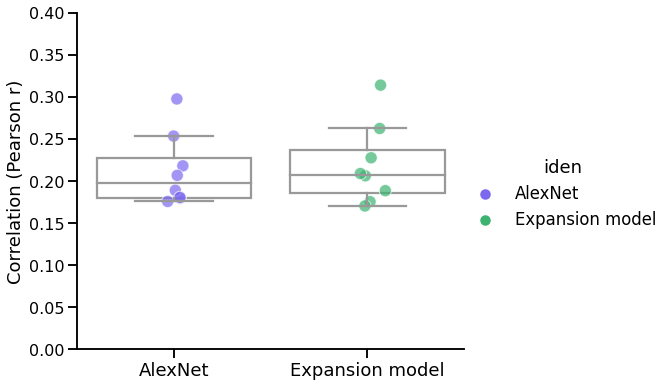

In [154]:
dataset = 'naturalscenes'
regions = ['V4']
mode = 'test'
MAX_POOL = True

data_dict = {
            'alexnet':{
                'iden':'alexnet',
                #'model':EngModel3LAbsBPAP(filters_3 = 1000, global_mp = MAX_POOL).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessGS, 
                'num_layers':5,
                'num_features':256,
                'dim_reduction_type':None,
                'max_pool':MAX_POOL,
                'n_dims': None,
                'alphas': 'alexnet_mp'},   
    
    
        'model abs 3x3 bp 224 ap 256 pcs':{
                'iden':'model_abs_3x3_bp_224_ap',
                #'model':EngModel3LAbsBPAPPCA(filters_3 = 10000, n_components= 256, global_mp = MAX_POOL).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessGS, 
                'num_layers':3,
                'num_features':10000,
                'dim_reduction_type':'pca',
                'n_dims':256,
                'max_dims':256,
                'pca_dataset':'nsd',
                'max_pool':MAX_POOL,
                'alphas': 'model_abs_3x3_bp_224_ap_mp_pca'},

}
        
name_dict = {'model_abs_3x3_bp_224_ap':'Expansion model',
             'alexnet':'AlexNet'}

palette = {'AlexNet':'orange', 'Expansion model':'green'}


model_nums = {'Expansion model':1, 'AlexNet':0}

palette = {'AlexNet':'mediumslateblue', 
           'Expansion model':'mediumseagreen'}


plot_subject_means(data_dict = data_dict, dataset=dataset, regions=regions, mode=mode, palette=palette, model_nums=model_nums, 
                   opacity=0.7, height=6, aspect=1.2, size=150, 
                       params = (6,4), name_dict = name_dict, file_name = 'alexnet vs model', show_legend = False) 


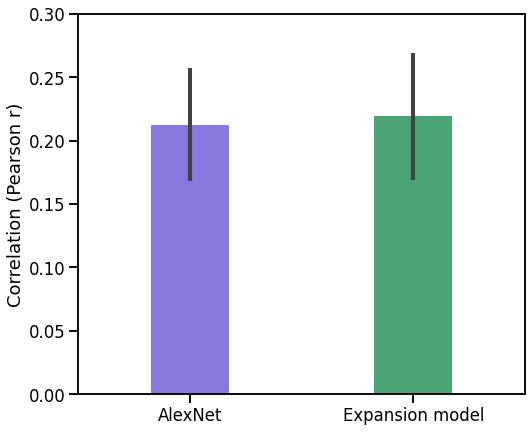

In [12]:
dataset = 'naturalscenes'
regions = ['V4']
#regions = ['general']
# dataset = 'majajhong'
# regions = ['V4']

mode = 'test'
MAX_POOL = True

dataset = 'naturalscenes'
regions = ['V4']
mode = 'test'
MAX_POOL = True

baseline_dict = {
            'alexnet':{
                'iden':'alexnet',
                #'model':EngModel3LAbsBPAP(filters_3 = 1000, global_mp = MAX_POOL).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessGS, 
                'num_layers':5,
                'num_features':256,
                'dim_reduction_type':None,
                'max_pool':MAX_POOL,
                'n_dims': None,
                'alphas': 'alexnet_mp'},   
    
    
        'model abs 3x3 bp 224 ap 256 pcs':{
                'iden':'model_abs_3x3_bp_224_ap',
                #'model':EngModel3LAbsBPAPPCA(filters_3 = 10000, n_components= 256, global_mp = MAX_POOL).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessGS, 
                'num_layers':3,
                'num_features':10000,
                'dim_reduction_type':'pca',
                'n_dims':256,
                'max_dims':256,
                'pca_dataset':'nsd',
                'max_pool':MAX_POOL,
                'alphas': 'model_abs_3x3_bp_224_ap_mp_pca'},

}
        
name_dict = {'model_abs_3x3_bp_224_ap':'Expansion model',
             'alexnet':'AlexNet'}

baseline_palette = {'AlexNet':'mediumslateblue', 
           'Expansion model':'mediumseagreen'}        


plt.clf()
plot_baselines(dataset, regions, mode,  aspect = 0.5, height =6.5, show_legend= False, ylim = (0.0, 0.3),
                                params= (8,7), baseline_dict = baseline_dict, baseline_palette = baseline_palette,
                                name_dict= name_dict, file_name = 'alexnet vs model')